In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import torch
from torch import nn, optim

In [2]:
from tqdm.notebook import tqdm

In [3]:
import torch.nn.functional as F

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")  

In [6]:
dataset_train = list()


# 1. Train Data Pairs
with open('train_job/train.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):

        if i == 0:
            pass
        else:
            dataset_train.append([line[0], line[1], int(line[2])])

# 2. Job id to number/ Job tags

job_dict = dict()

with open('train_job/job_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
        else:
            try:
                job_dict[line[0]].append(line[1])
            except KeyError:
                job_dict[line[0]] = [line[1]]
                
# 3. Job id to company code and size. Not using right now
                
company_set = set()
jobs_set = set()
company_size_set = set()
job_id_to_com_size_dict = dict()

scales = {'': 0, 
          '1-10': 1, 
          '11-50': 2, 
          '51-100': 3, 
          '101-200': 4, 
          '201-500': 5, 
          '501-1000': 6, 
          '1000 이상': 7}

with open('train_job/job_companies.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
#             print(line)
        else:
            company_set.add(line[0])
            jobs_set.add(line[1])
            company_size_set.add(line[2])
            job_id_to_com_size_dict[line[1]] = scales[line[2]]

# 4. User skills
            
user_dict = dict()

with open('train_job/user_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
    
            try:
                user_dict[line[0]].append(line[1])
            except KeyError:
                user_dict[line[0]] = [line[1]]

# 5. Job required skills
                
tag_dictionary = dict()
tag_idx_to_tag_list = list()

with open('train_job/tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
            tag_dictionary[line[0]] = i - 1
            tag_idx_to_tag_list.append(line)
            assert len(tag_idx_to_tag_list) == i
    
def tagID2Vector(tag_list):
    vector = np.zeros(len(tag_dictionary))
    
    for tag in tag_list:
        vector[tag_dictionary[tag]] = 1
    
    return vector

def jobID2Vector(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

def jobID2CompanyScale(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

In [7]:
for job in job_dict:
    assert len(job_dict[job]) == len(set(job_dict[job]))

In [8]:
def collate_function(data_input):

    global user_dict
    
    person_id_list = list()
    job_id_list = list()
    answer = list()

    for data in data_input:
        person_id_list.append(data[0])
        job_id_list.append(data[1])
        answer.append(data[2])
    
    person_tensor = list()
    for person_id in person_id_list:
        user_skill_set = set(user_dict[person_id])
        vector = tagID2Vector(user_skill_set)
        person_tensor.append(vector)
    person_tensor = torch.tensor(person_tensor)
        
    job_tensor = list()
    for job_id in job_id_list:
        vector = jobID2Vector(job_id)
        job_tensor.append(vector)
    job_tensor = torch.tensor(job_tensor)
        
    answer_tensor = torch.tensor(answer)
      
    com_size_tensor = list()
    for job_id in job_id_list:
        com_size_tensor.append(job_id_to_com_size_dict[job_id])
    com_size_tensor = torch.tensor(com_size_tensor)
    
        
    return person_tensor, job_tensor, answer_tensor, com_size_tensor

In [9]:
dataloader = DataLoader(dataset_train, 
                        batch_size=12, 
                        shuffle=True, 
                        num_workers=4, 
                        collate_fn=collate_function)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.residual_layers = nn.ModuleList([nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                              nn.Linear(887 * 3, 887 * 3), 
                                    ])
        
#         self.norm_layers = nn.ModuleList([torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3),
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                           torch.nn.BatchNorm1d(887 * 3), 
#                                     ])
        
        
        
#         self.layers = nn.ModuleList([nn.Linear(887 * 3, 2 ** 11), 
#                                      nn.Linear(2 ** 11, 2 ** 10),
#                                      nn.Linear(2 ** 10, 2 ** 9),
#                                      nn.Linear(2 ** 9, 2 ** 8),
#                                      nn.Linear(2 ** 8, 2 ** 7),
#                                      nn.Linear(2 ** 7, 2 ** 6),
#                                      nn.Linear(2 ** 6, 2 ** 5),
#                                      nn.Linear(2 ** 5, 2 ** 4),
#                                      nn.Linear(2 ** 4, 2 ** 3),
#                                      nn.Linear(2 ** 3, 2 ** 2),
#                                      nn.Linear(2 ** 2, 2 ** 1),
#                                     ])

        self.layers = nn.ModuleList([nn.Linear(887 * 3, 2 ** 11), 
                                     nn.Linear(2 ** 11, 2 ** 10),
                                     nn.Linear(2 ** 10, 2 ** 10),
                                     nn.Linear(2 ** 10, 2 ** 1),
                                    ])
    
        self.dropout = nn.Dropout(p=0.05)
        
        self.last_layer = nn.Linear(2 ** 1, 2 ** 1)

    def forward(self, tensor):
        
        tensor_input = tensor
        
#         for layer, norm_layer in zip(self.residual_layers, self.norm_layers):
        for layer in self.residual_layers:
#             tensor = F.relu(layer(tensor)) + tensor
#             tensor = norm_layer(F.relu(layer(tensor)))
            t_input = tensor
            tensor = F.relu(layer(tensor))
#             tensor = self.dropout(tensor)
            tensor += t_input
        
        for layer in self.layers:
            tensor = F.relu(layer(tensor))
#             tensor = self.dropout(tensor)
#             tensor = layer(tensor)
        
        tensor = self.last_layer(tensor)
        
        tensor = F.softmax(tensor)
        
        return tensor


In [11]:
def accuracy(pred, label):
    
    assert len(pred) == len(label)
    
#     pred_label = np.floor(pred + 0.5)
    
    acc = 0
    
#     print(pred, label)
    
#     for i in range(len(pred)):
#         if pred_label[i] == label[i]:
#             acc += 1

#     return acc / len(pred_label)

    label_pred = [np.argmax(elem) for elem in pred]
    
    for i in range(len(pred)):
        if label_pred[i] == label[i]:
            acc += 1
            
    return acc / len(label_pred)

/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension 

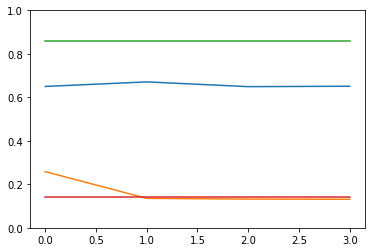

Acc. 0.16419141914191418
Loss 0.6553521311961779


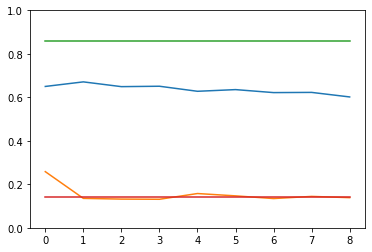

Acc. 0.1443894389438944
Loss 0.6219337343579472


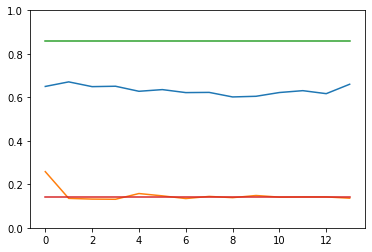

Acc. 0.1419141914191419
Loss 0.6269475575130765


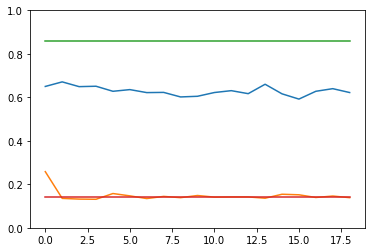

Acc. 0.14603960396039603
Loss 0.6195561685184442


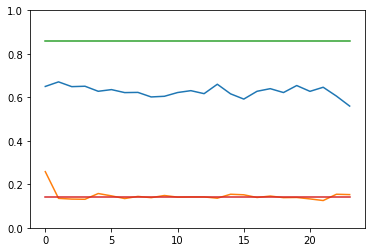

Acc. 0.14092409240924092
Loss 0.6187336716321435


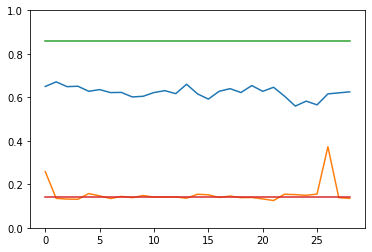

Acc. 0.19026402640264023
Loss 0.6019286571162762


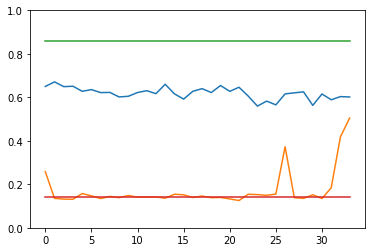

Acc. 0.27871287128712874
Loss 0.5944253041602597


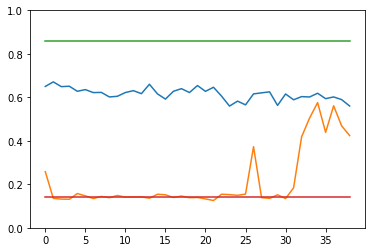

Acc. 0.49372937293729374
Loss 0.5928324914804779


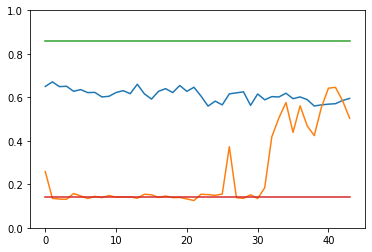

Acc. 0.5858085808580858
Loss 0.5770447384012808


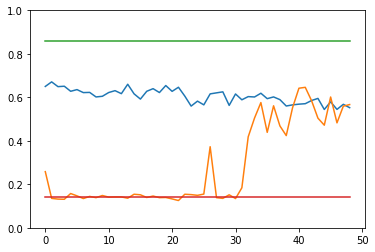

Acc. 0.5364686468646864
Loss 0.5576721121178995


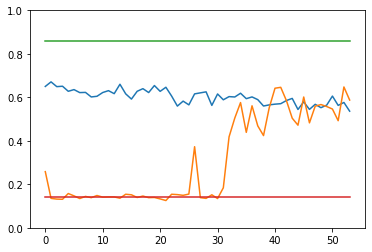

Acc. 0.5663366336633663
Loss 0.5691236151917145


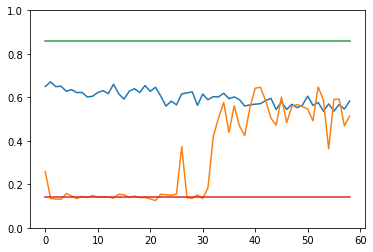

Acc. 0.5056105610561057
Loss 0.5606188453660154


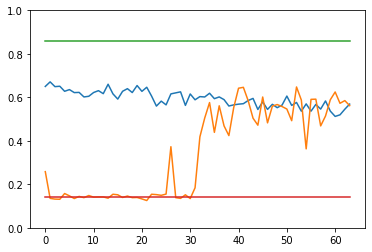

Acc. 0.5866336633663366
Loss 0.5365186772724189


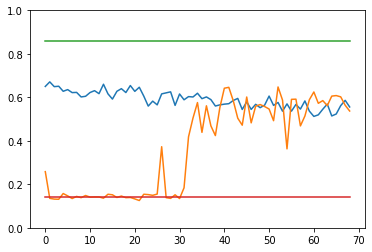

Acc. 0.5833333333333334
Loss 0.5483024766539584


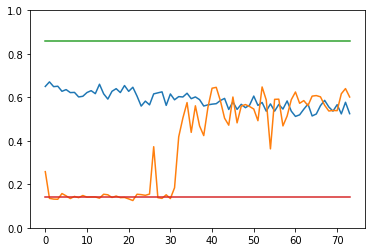

Acc. 0.5872937293729372
Loss 0.5457618637840347


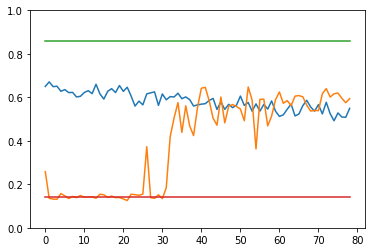

Acc. 0.6001650165016501
Loss 0.5175745559800969


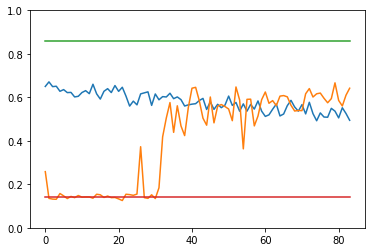

Acc. 0.6128712871287129
Loss 0.5228208682324627


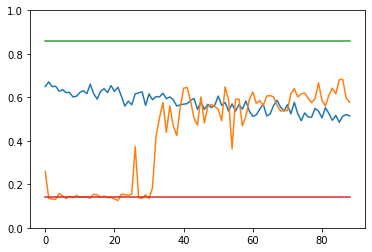

Acc. 0.6308580858085808
Loss 0.5102881641081064


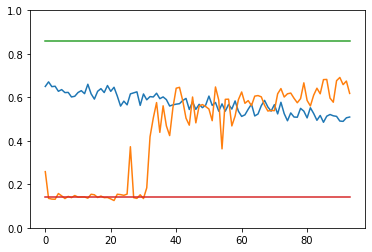

Acc. 0.6638613861386139
Loss 0.5016348772119767


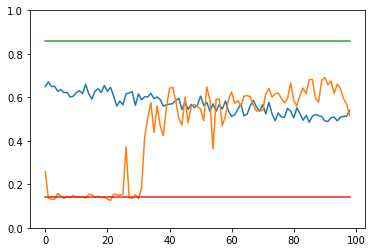

Acc. 0.5963696369636964
Loss 0.5130671917211892


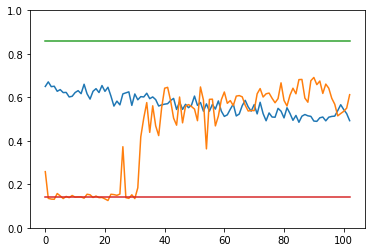

Acc. 0.5476897689768977
Loss 0.5333622467989969


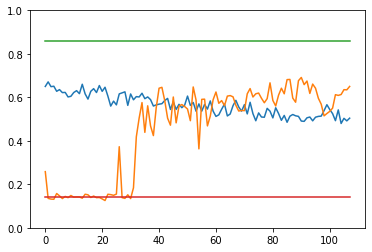

Acc. 0.6283828382838283
Loss 0.5042664763360921


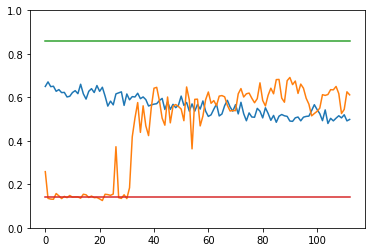

Acc. 0.5848184818481847
Loss 0.5061212762157516


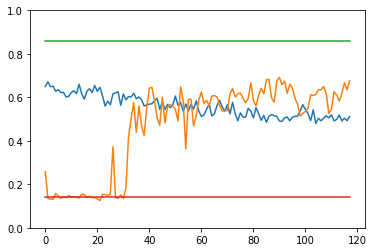

Acc. 0.6356435643564355
Loss 0.5037446557295204


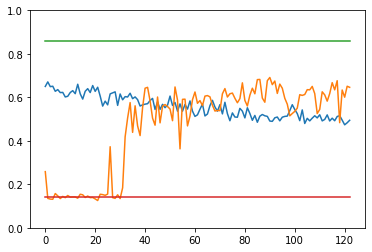

Acc. 0.602970297029703
Loss 0.4924288414492466


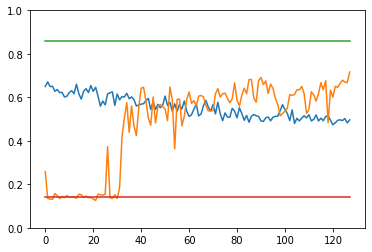

Acc. 0.6793729372937294
Loss 0.4941628919969691


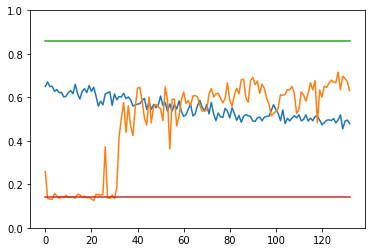

Acc. 0.6641914191419142
Loss 0.4877610191260233


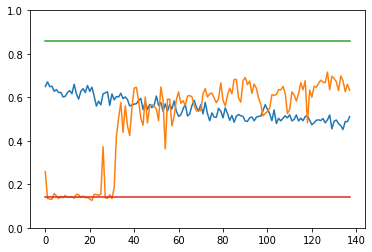

Acc. 0.6585808580858087
Loss 0.481979385165885


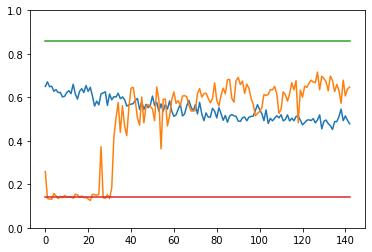

Acc. 0.6287128712871287
Loss 0.5050779438254857


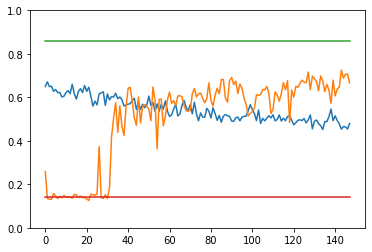

Acc. 0.6985148514851485
Loss 0.463512397992729


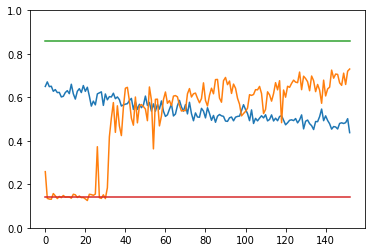

Acc. 0.6952145214521452
Loss 0.4771296350672694


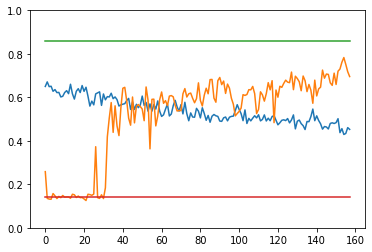

Acc. 0.7419141914191418
Loss 0.4464599927463153


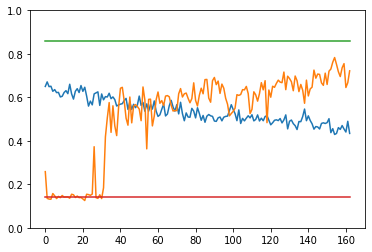

Acc. 0.705115511551155
Loss 0.45777888109188264


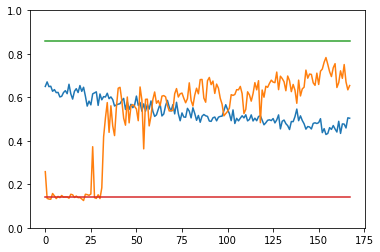

Acc. 0.6795379537953795
Loss 0.48475138261766715


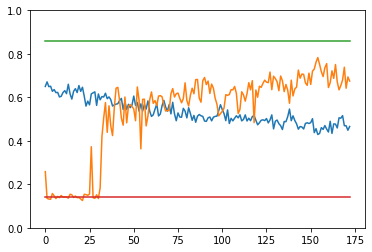

Acc. 0.6858085808580857
Loss 0.47384859949055286


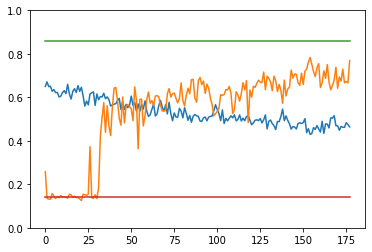

Acc. 0.7008250825082508
Loss 0.469401740437687


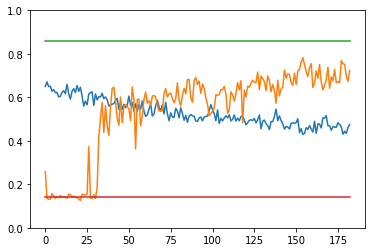

Acc. 0.7202970297029702
Loss 0.44897636747596287


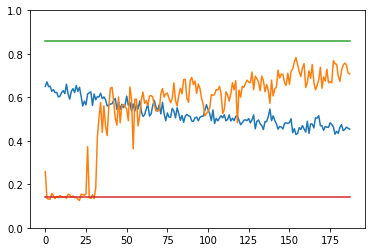

Acc. 0.7351485148514852
Loss 0.4547791363579212


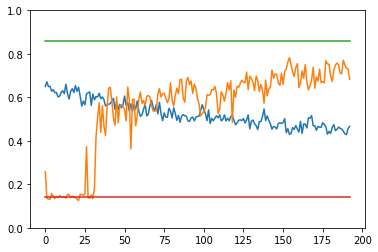

Acc. 0.7333333333333333
Loss 0.4456396442828792


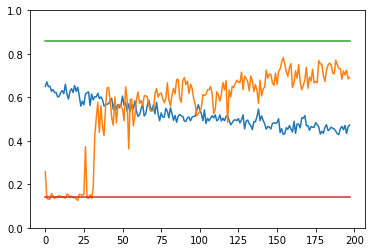

Acc. 0.7051155115511551
Loss 0.45842249682634184


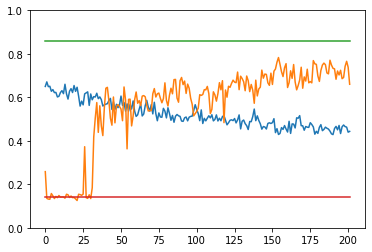

Acc. 0.7196369636963696
Loss 0.45685356241641656


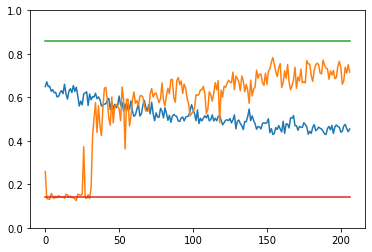

Acc. 0.7184818481848184
Loss 0.45938156736959324


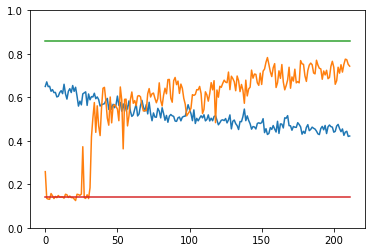

Acc. 0.759075907590759
Loss 0.4303428985104703


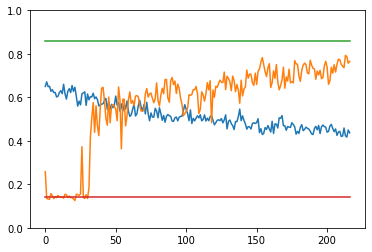

Acc. 0.7676567656765676
Loss 0.43705396817462283


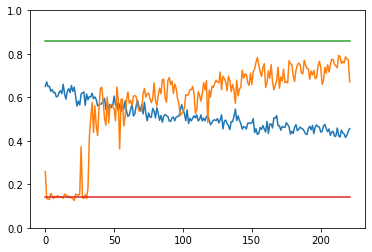

Acc. 0.7533003300330032
Loss 0.4346412382503548


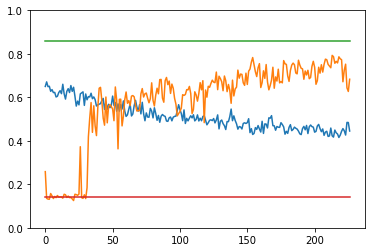

Acc. 0.6863036303630363
Loss 0.45731217548398695


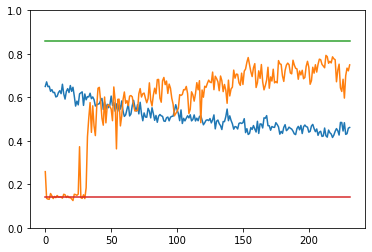

Acc. 0.7003300330033002
Loss 0.4530625976548337


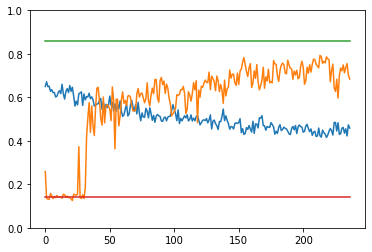

Acc. 0.7183168316831683
Loss 0.44910763177541224


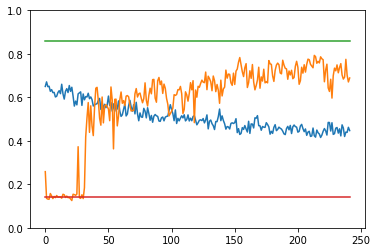

Acc. 0.7057755775577558
Loss 0.44166776650022754


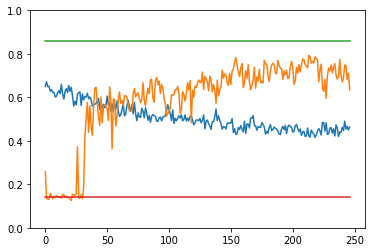

Acc. 0.7046204620462045
Loss 0.4648937997841599


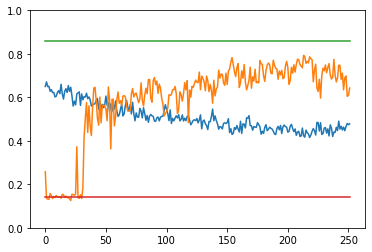

Acc. 0.6488448844884489
Loss 0.46890847948518133


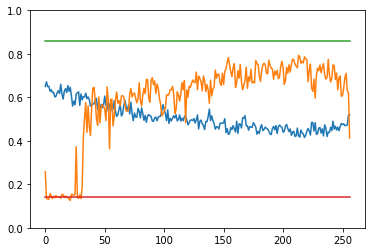

Acc. 0.613036303630363
Loss 0.4902303584141306


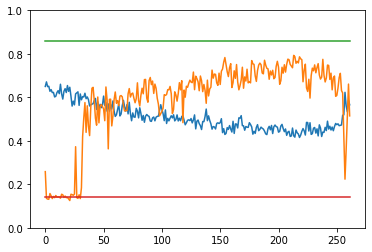

Acc. 0.45495049504950497
Loss 0.5737701479751285


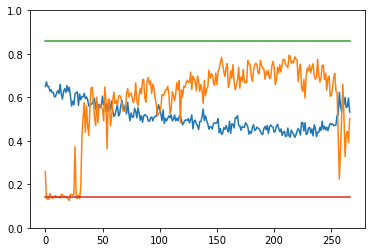

Acc. 0.4191419141914191
Loss 0.5676531356750149


KeyboardInterrupt: 

In [12]:


# 모델 초기화
model = Net().to(device)

# 옵티마이저 초기화
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# weights = [1.0, 6.0]
weights = [1.0, 24.0]
# weights = [1.0, 12.0]

class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

loss_history = list()
acc_history = list()

running_loss = list()
running_acc = list()

for i in range(120):

    for i, (p_tensor, j_tensor, a_tensor, c_tensor) in tqdm(enumerate(dataloader)):

    #     print(i)
    #     print(p_tensor.shape)
    #     print(j_tensor.shape)
    #     print(a_tensor.shape)

        p_tensor = torch.tensor(p_tensor, dtype=torch.float32)
        j_tensor = torch.tensor(j_tensor, dtype=torch.float32)
        a_tensor = torch.tensor(a_tensor, dtype=torch.int64)

        s_tensor = torch.clamp(j_tensor - p_tensor, 0, 1)

        input_tensor = torch.cat((p_tensor, j_tensor, s_tensor), 1)

        model.zero_grad()

        pred_tensor = model(input_tensor.to(device))

    #     pred_tensor = torch.tensor(pred_tensor, dtype=torch.float64)

    #     print(pred_tensor.dtype)
    #     print(a_tensor.dtype)

        loss = criterion(pred_tensor, a_tensor.to(device))
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_acc.append(accuracy(pred_tensor.cpu().detach().numpy(), 
                           a_tensor.cpu().detach().numpy()))
        
        if len(running_loss) > 100:
            loss_history.append(np.mean(running_loss))
            acc_history.append(np.mean(running_acc))
            running_loss = list()
            running_acc = list()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.plot([0.8571] * len(acc_history))
    plt.plot([0.1428] * len(acc_history))
    plt.ylim([0, 1])
    plt.show()
    
    print(f'Acc. {np.mean(acc_history[-5:])}')
    print(f'Loss {np.mean(loss_history[-5:])}')